# Numerical modelling of synaptic transmission in 3D

In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from getplate import getPlate
from getCylinder import GetCylinder

from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output

In [2]:
%%html 
<style>
.output_wrapper button.btn.btn-default, .output_wrapper .ui-dialog-titlebar {
    display: none;
} </style>

## 3D
* Build mass matrix and load vector
* Need new mesh generator, new matrix and load vector builder, otherwise the same
* Solve system of ODE's
* More complicated animation

In [11]:
N = 100
n = 5
p, tri, bottom, middle, top = GetCylinder(N,n)

<IPython.core.display.Javascript object>


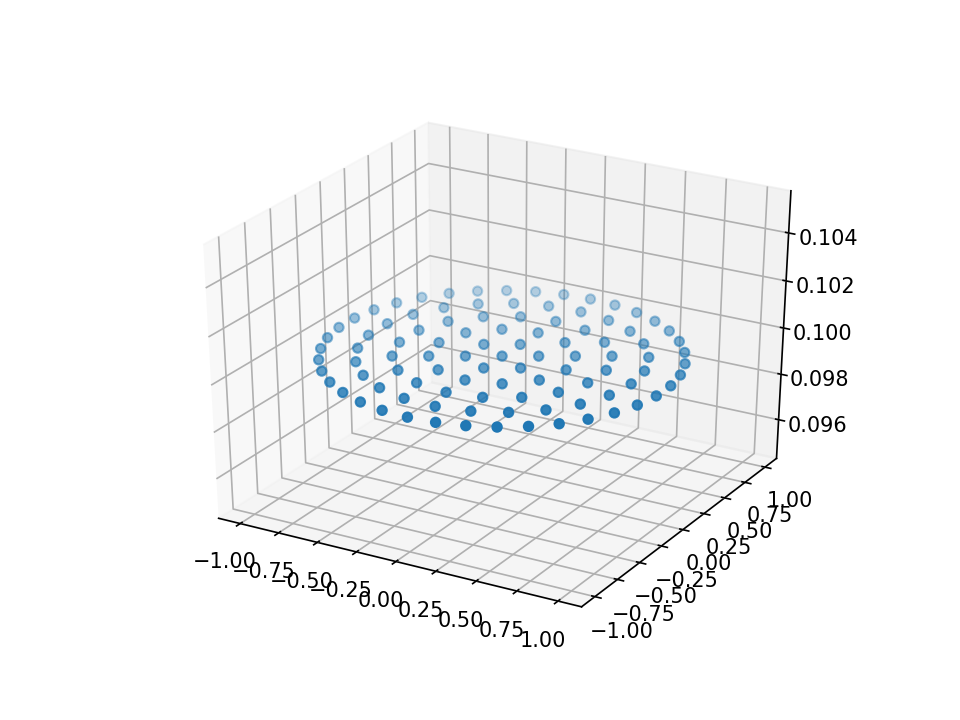

In [12]:
ax = plt.axes(projection='3d')

ax.scatter3D(p[top,0], p[top,1], p[top,2], cmap='Greens');